## Collaborative/Personalized Learning

In [1]:
%matplotlib inline
import sys
import os
main_path = os.path.abspath('../')
if main_path not in sys.path:
    sys.path.append(main_path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel

from online_kernels.klms import KLMS
from online_kernels.knlms import KNLMS
from online_kernels.krls import KRLS
from online_kernels.klmsRFF import klms_rff
from online_kernels.knlmsRFF import knlms_rff
from online_kernels.krlsRFF import krls_rff

from data.datasets import load_dodd
from sklearn.utils import shuffle
from scipy.optimize import nnls

import scipy.io as sio
from sklearn.linear_model import LinearRegression
from scipy.sparse import spdiags

from PL_functions import W_norm

In [2]:
def load_kuh(num_data,coeff):
    '''
    N: Number Distributed Systems
    coeff: array of coefficients
    '''
    
#     v = 0.1*np.random.normal(0,1,num_data+2) 
    d_true =[0.1 , 0.1]
    d = [d_true[0], d_true[1]]

    # Grab new data
    new_d_true = lambda x: x.append((coeff[0] - coeff[1] * np.exp(-(x[-1]**2)))*x[-1] - (coeff[2] + coeff[4]*np.exp(-(x[-1]**2)))*x[-2] + coeff[5]*np.sin(np.pi*x[-1]))
    new_d = lambda x: x.append((coeff[0]- coeff[1] * np.exp(-(x[-1]**2)))*x[-1] - (coeff[2] + coeff[4]*np.exp(-(x[-1]**2)))*x[-2] + coeff[5]*np.sin(np.pi*x[-1]) + np.random.normal(0.0,0.1))    
    for i in range(2,num_data+2):
        new_d_true(d_true)
        new_d(d)
#         d.append(d_true[-1] + v[i])
    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))

    d_true = d_true[2::]
    d = d[2::]
    return np.array(u),np.array(d),np.array(d_true)

In [3]:
N = 20
trainX = []
trainY = []
max_num_data = 60
coeffs = np.round(np.random.rand(N,6),2)
for n in range(N):
    num_data_n = np.random.randint(max_num_data - 30,max_num_data)
    u,d,d_true = load_kuh(num_data_n,coeffs[n])
    trainY.append(np.array([d]))
    trainX.append(u.T)
# trainX = np.array(trainX,dtype=object)
# trainY = np.array(trainY,dtype=object)

Text(0.5, 0, 'Time')

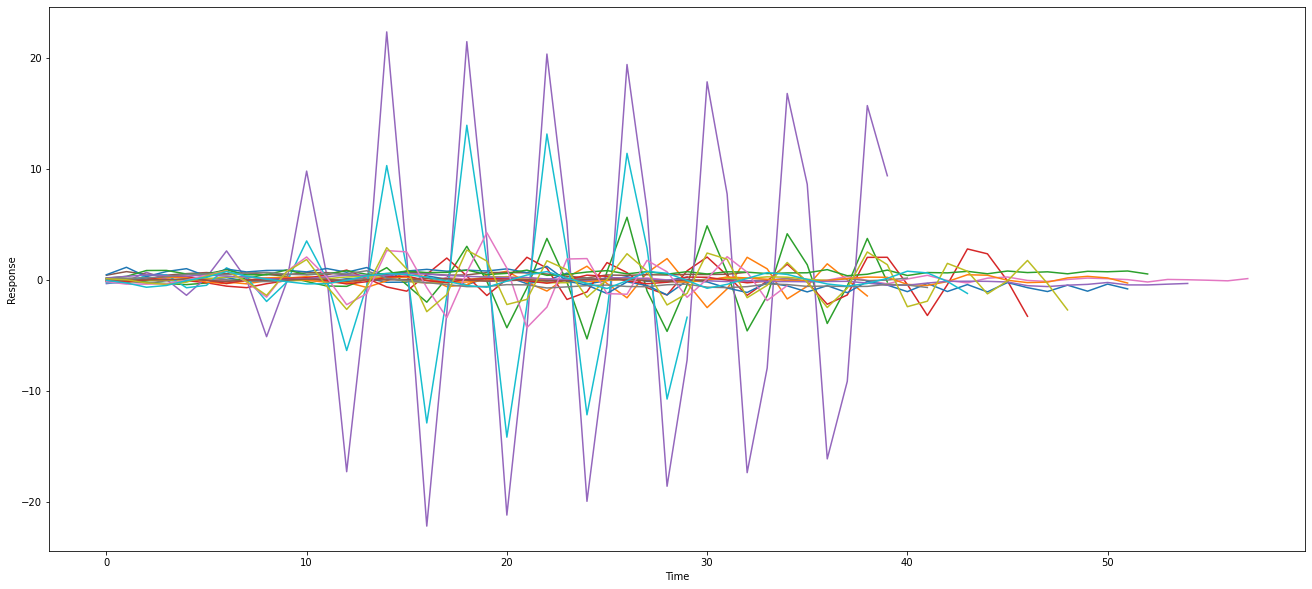

In [4]:
plt.figure(figsize=(7.5*3, 10))
for n in range(N):
    plt.plot(trainY[n].T)
plt.ylabel("Response")
plt.xlabel("Time")
# plt.savefig(main_path + '/results/wcci/trainingdata.png',format='png',bbox_inches='tight')

In [ ]:
# p,N = W.shape
# B0 = B @ W
# BIGM = []
# for i in range(N):
#     reg = LinearRegression().fit(np.vstack((np.ones(trainX[0].shape[1]),trainX[0])).T, trainY[0].T)
#     BIGM.append(reg.coef_[0])
print(len(trainY))

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 57.85it/s]


Text(0.5, 0, 'iteration')

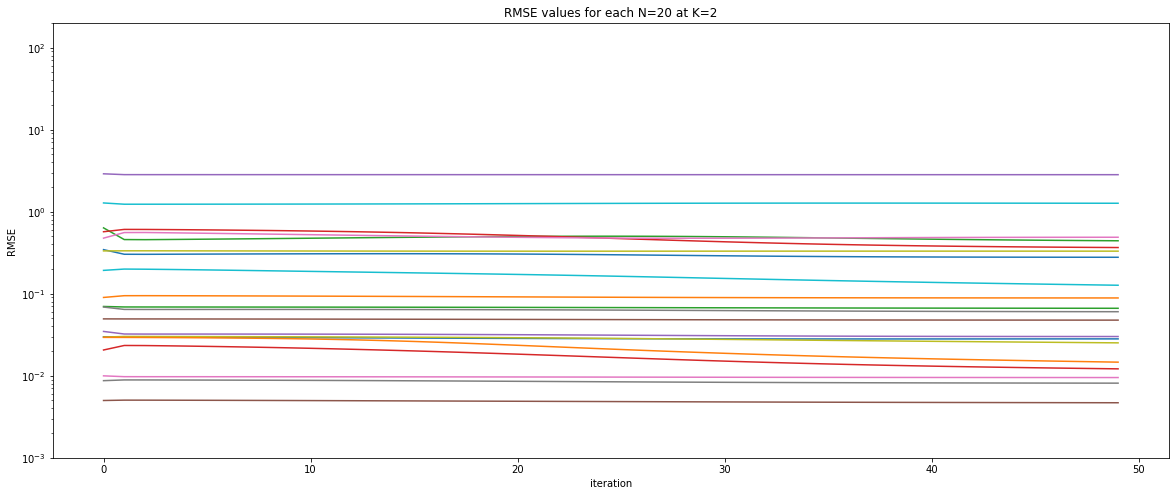

In [7]:
iteration = 50
alpha = 0
Norm = 0
Y = trainY
T = trainX
K = 2
N = len(Y)
n = len(T[0])
m_i = []
U = []
for i in range(N):
    m_i.append(Y[i].shape[1])
    if T[i].shape[1] == Y[i].shape[1]:
        U.append(T[i] @ Y[i].T)
        
A = np.random.rand(n,K)
C = np.random.rand(K,N)

C = W_norm(C, Norm)

rmse = np.zeros((iteration,N))
for epoch in tqdm(range(iteration)): 
    
    XX = np.zeros((n*K,n*K))
    B = np.zeros((n*K,1))
    X = [np.zeros((m_i[i],n*K)) for i in range(N)]
    for i in range(N):
        for j in range(m_i[i]):
            r = []
            for v in range(n):
                r = np.hstack((r,T[i][v,j]* C.T[i]))

            X[i][j] = r
        XX += X[i].T @ X[i] + 2 * np.eye(n*K)
        B += X[i].T @ Y[i].T
    a = np.linalg.pinv(XX) @ B
    a = a.T[0]
    A = np.zeros((n,K))

    for v in range(n):
        A[v] = a[v*K:(v+1)*K]

    AV = []
    AU = []
    for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
        AU.append(A.T @ T[i] @ Y[i].T)
        AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

    C = C * np.divide(AU,AV)[:,:,0].T        

    for i in range(N):
        AC = A @ C
        rmse[epoch][i] = np.mean((AC.T[i] @ trainX[i] - trainY[i])**2)

# plt.figure(figsize=(2*10, 6))
plt.figure(figsize=(20, 8))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.title('RMSE values for each N='+str(N)+' at K=' + str(K))
plt.ylabel("RMSE")
plt.ylim([1e-3,2e2])
# plt.ylim([0.000001,1.5])
plt.xlabel("iteration")

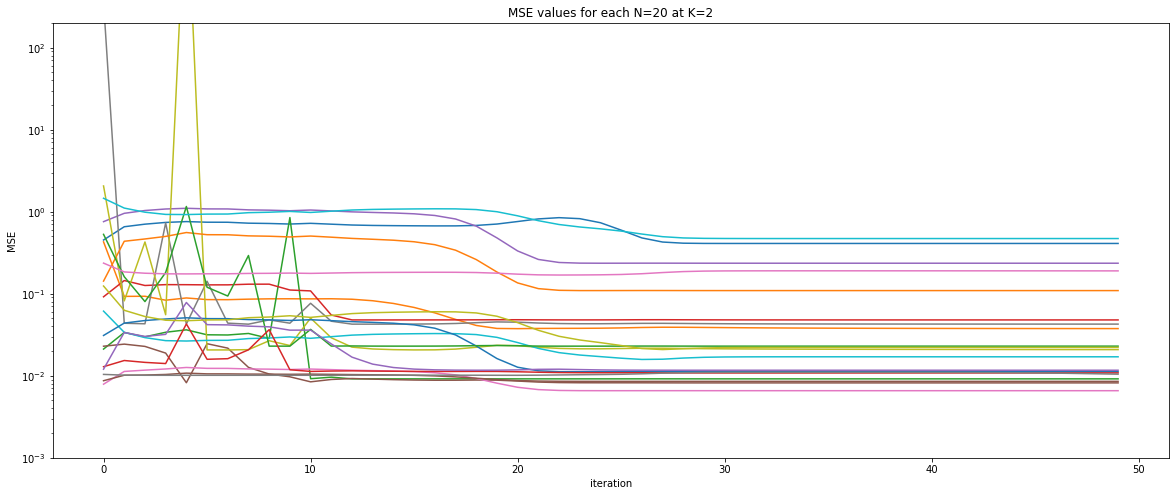

In [6]:
plt.figure(figsize=(20, 8))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.ylim([4e1,6e2])    
plt.title('MSE values for each N='+str(N)+' at K=' + str(K))
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.ylim([1e-3,2e2])
plt.savefig(main_path + '/results/wcci/regpl.png',format='png',bbox_inches='tight')

# Kernel mapping

In [ ]:
iteration = 50
D = 100
Y = trainY
T = trainX

alpha = 0
Norm = 0
N = len(Y)
K = 2
n = T[0].shape[0]
kernel = Kernel(5.73)
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(size=(n,D))
b = np.random.uniform(0,2*np.pi,(D,1))
h = []
m_i = []
U = []

for i in range(N):
    h.append(np.sqrt(2/D) * np.cos(W.T @ T[i] + b))    
    m_i.append(Y[i].shape[1])
    if T[i].shape[1] == Y[i].shape[1]:
        U.append(T[i] @ Y[i].T)
T = h
A = np.random.rand(D,K)
C = np.random.rand(K,N)

# C = W_norm(C, Norm)

rmse = np.zeros((iteration,N))
for epoch in tqdm(range(iteration)): 

    XX = np.zeros((D*K,D*K))
    B = np.zeros((D*K,1))
    X = [np.zeros((m_i[i],D*K)) for i in range(N)]
    for i in range(N):
        for j in range(m_i[i]):
            r = []
            for v in range(D):
                r = np.hstack((r,T[i][v,j]* C.T[i]))
            X[i][j] = r
        XX += X[i].T @ X[i] + 2 * np.eye(D*K)
        B += X[i].T @ Y[i].T
    a = np.linalg.pinv(XX) @ B
    a = a.T[0]
    A = np.zeros((D,K))

    for v in range(D):
        A[v] = a[v*K:(v+1)*K]

    AV = []
    AU = []
    for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
       AU.append(A.T @ T[i] @ Y[i].T)
       AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

    C = C * np.divide(AU,AV)[:,:,0].T        
        
    for i in range(N):
        AC = A @ C
        rmse[epoch][i] = np.mean((h[i].T @ AC.T[i]  - trainY[i])**2)

plt.figure(figsize=(2*10, 6))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.title('RMSE values for each N='+str(N)+' at K=' + str(K) + ' and D=' +str(D))
plt.ylabel("RMSE")
plt.xlabel("iteration")
plt.ylim([1e-3,2e2])
# plt.ylim([0.000001,1.5])

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.title('MSE values for each N='+str(N)+' at K=' + str(K))
plt.ylabel("MSE")
plt.ylim([1e-3,2e2])
plt.xlabel("iteration")
plt.savefig(main_path + '/results/wcci/kernelpl.png',format='png',bbox_inches='tight')

In [ ]:
iteration = 100
mse = np.zeros(iteration)
# Kernel Dictionary size

step_size = 0.8
num_data = 3000
num_experiments = 1
amse = np.zeros(iteration)
kernel = Kernel(3.73)
# N individuals
N = 100 # mFea
# L canonical models
L = 3 # k
D = 100 # p
KLMS_RFF = klms_rff(step_size,D)
for epoch in tqdm(range(num_experiments)):
    A = np.random.rand(D,L) # B
    C = np.random.rand(L,N) # membership weight matrix W
#     A = np.zeros((D,L))
#     C = np.zeros((L,N))    
    u,d,d_true = load_dodd(num_data)
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(2,D))
    b = np.random.uniform(0,2*np.pi,(D,1))
    h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
    K = []

    for n in range(iteration):
        Y_hat = []
        Y = []
        err = 0
        # Learning A gived fixed Cs (Least Squares)
        B = np.zeros((D,N))
        m = 0
        for i in range(N):
    #         m_i = np.random.randint(1,20)  # nSmp
            m_i = 10
            m += m_i
            K_i = np.zeros((D,m_i))
            Y_i = np.zeros((m_i,))
            c_i = C.T[i]
            for samples in range(m_i):
                v = np.random.randint(len(d))
                h_n = h[:,v].reshape((D,1))
                d_n = np.array([d[v]])
                K_i.T[samples] = h_n.reshape((D,))
                Y_i[samples] = d_n
                if samples > 0:
                    alpha_in = alpha_out
                else:
                    alpha_in = (A @ c_i).reshape((D,1))
                _,alpha_out = KLMS_RFF.train(h_n,d_n,alpha_in)

            K.append(K_i)
            Y.append(Y_i)

            B.T[i] = alpha_out.reshape((D,))
    #         XX = np.zeros((D,L))
    #         XY = np.zeros(D*L,)
    #         X = []
    #         for i in range(N):
    #             for j in range(m_i):
    #                 r = []
    #                 for v in range(D):
    #                     print(i,j,v)
    #                     r.append(K[i][v][j] * C.T[i])
    #                 X.append(r)

    # Least squares ||B - AC||^2
        A = B.dot(np.linalg.pinv(C))
    #     A_hat,_,_,_ = np.linalg.lstsq(C.T, B.T,rcond=None)
    #     A = A_hat.T

    # CXVPY approach: Not working
    #     A_hat = cp.Variable((D,L))
    #     obj = cp.sum([cp.sum_squares(Y[i] - K[i].T @ A_hat @ C.T[i]) for i in range(N)])
    #     constraints = [K[i].T@ A_hat >=0 for i in range(N)]
    #     prob = cp.Problem(cp.Minimize(obj),constraints)
    #     prob.solve()
    #     A = A_hat.value

        # Learning C given the A are fixed
        for i in range(N):
            y_i = Y[i]
            AK = A.T @ K[i]
            AKy = AK @ y_i
            AKKAc = AK @ AK.T @ C.T[i]
            for k in range(L):
                C[k][i] = np.multiply(C[k][i],np.divide(AKy[k],AKKAc[k]))

            Y_hat.append(K[i].T @ A @ C.T[i])  
            err+=np.sqrt(np.mean(np.square(Y[i] - Y_hat[i]))/N)

        mse[n] = err
    amse += mse/num_experiments
plt.figure(figsize=(2*10, 6))
plt.semilogy(range(len(amse)),amse,label="KLMS")
plt.legend()
# plt.ylim([1e-2,1e0])
# plt.xlim([0,1000])
plt.ylabel("MSE")
plt.xlabel("iteration")

In [ ]:
print(n)

In [ ]:
iteration = 50
D = 200
Y = trainY
T = trainX

alpha = 0
Norm = 0
N = len(Y)
K = 5
n = T[0].shape[0]
kernel = Kernel(5.73)
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(size=(n,D))
b = np.random.uniform(0,2*np.pi,(D,1))
h = []
m_i = []
U = []

for i in range(N):
    h.append(np.sqrt(2/D) * np.cos(W.T @ T[i] + b))    
    m_i.append(Y[i].shape[1])
    if T[i].shape[1] == Y[i].shape[1]:
        U.append(T[i] @ Y[i].T)
T = h
A = np.random.rand(D,K)
C = np.random.rand(K,N)

# C = W_norm(C, Norm)

rmse = np.zeros((iteration,N))
for epoch in tqdm(range(iteration)): 

    XX = np.zeros((D*K,D*K))
    B = np.zeros((D*K,1))
    X = [np.zeros((m_i[i],D*K)) for i in range(N)]
    for i in range(N):
        for j in range(m_i[i]):
            r = []
            for v in range(D):
                r = np.hstack((r,T[i][v,j]* C.T[i]))
            X[i][j] = r
        XX += X[i].T @ X[i] + 2 * np.eye(D*K)
        B += X[i].T @ Y[i].T
    a = np.linalg.pinv(XX) @ B
    a = a.T[0]
    A = np.zeros((D,K))

    for v in range(D):
        A[v] = a[v*K:(v+1)*K]

    AV = []
    AU = []
    for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
       AU.append(A.T @ T[i] @ Y[i].T)
       AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

    C = C * np.divide(AU,AV)[:,:,0].T        
        
    for i in range(N):
        AC = A @ C
        rmse[epoch][i] = np.mean((h[i].T @ AC.T[i]  - trainY[i])**2)

plt.figure(figsize=(2*10, 6))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.title('RMSE values for each N='+str(N)+' at K=' + str(K) + ' and D=' +str(D))
plt.ylabel("RMSE")
plt.xlabel("iteration")
plt.ylim([1e-3,2e2])
iteration = 50
D = 100
Y = trainY
T = trainX

alpha = 0
Norm = 0
N = len(Y)
K = 2
n = T[0].shape[0]
kernel = Kernel(5.73)
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(size=(n,D))
b = np.random.uniform(0,2*np.pi,(D,1))
h = []
m_i = []
U = []

for i in range(N):
    h.append(np.sqrt(2/D) * np.cos(W.T @ T[i] + b))    
    m_i.append(Y[i].shape[1])
    if T[i].shape[1] == Y[i].shape[1]:
        U.append(T[i] @ Y[i].T)
T = h
A = np.random.rand(D,K)
C = np.random.rand(K,N)

# C = W_norm(C, Norm)

rmse = np.zeros((iteration,N))
for epoch in tqdm(range(iteration)): 

    XX = np.zeros((D*K,D*K))
    B = np.zeros((D*K,1))
    X = [np.zeros((m_i[i],D*K)) for i in range(N)]
    for i in range(N):
        for j in range(m_i[i]):
            r = []
            for v in range(D):
                r = np.hstack((r,T[i][v,j]* C.T[i]))
            X[i][j] = r
        XX += X[i].T @ X[i] + 2 * np.eye(D*K)
        B += X[i].T @ Y[i].T
    a = np.linalg.pinv(XX) @ B
    a = a.T[0]
    A = np.zeros((D,K))

    for v in range(D):
        A[v] = a[v*K:(v+1)*K]

    AV = []
    AU = []
    for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
       AU.append(A.T @ T[i] @ Y[i].T)
       AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

    C = C * np.divide(AU,AV)[:,:,0].T        
        
    for i in range(N):
        AC = A @ C
        rmse[epoch][i] = np.mean((h[i].T @ AC.T[i]  - trainY[i])**2)
D = 100
Y = trainY
T = trainX

alpha = 0
Norm = 0
N = len(Y)
K = 2
n = T[0].shape[0]
kernel = Kernel(5.73)
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(size=(n,D))
b = np.random.uniform(0,2*np.pi,(D,1))
h = []
m_i = []
U = []

for i in range(N):
    h.append(np.sqrt(2/D) * np.cos(W.T @ T[i] + b))    
    m_i.append(Y[i].shape[1])
    if T[i].shape[1] == Y[i].shape[1]:
        U.append(T[i] @ Y[i].T)
T = h
A = np.random.rand(D,K)
C = np.random.rand(K,N)

# C = W_norm(C, Norm)

rmse = np.zeros((iteration,N))
for epoch in tqdm(range(iteration)): 

    XX = np.zeros((D*K,D*K))
    B = np.zeros((D*K,1))
    X = [np.zeros((m_i[i],D*K)) for i in range(N)]
    for i in range(N):
        for j in range(m_i[i]):
            r = []
            for v in range(D):
                r = np.hstack((r,T[i][v,j]* C.T[i]))
            X[i][j] = r
        XX += X[i].T @ X[i] + 2 * np.eye(D*K)
        B += X[i].T @ Y[i].T
    a = np.linalg.pinv(XX) @ B
    a = a.T[0]
    A = np.zeros((D,K))

    for v in range(D):
        A[v] = a[v*K:(v+1)*K]

    AV = []
    AU = []
    for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
       AU.append(A.T @ T[i] @ Y[i].T)
       AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

    C = C * np.divide(AU,AV)[:,:,0].T        
        
    for i in range(N):
        AC = A @ C
        rmse[epoch][i] = np.mean((h[i].T @ AC.T[i]  - trainY[i])**2)

plt.figure(figsize=(2*10, 6))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.title('RMSE values for each N='+str(N)+' at K=' + str(K) + ' and D=' +str(D))
plt.ylabel("RMSE")
plt.xlabel("iteration")
plt.ylim([1e-3,2e2])
# plt.ylim([0.000001,1.5])

plt.figure(figsize=(2*10, 6))
for i in range(N):
    plt.semilogy(range(len(rmse.T[i])),rmse.T[i])
plt.title('RMSE values for each N='+str(N)+' at K=' + str(K) + ' and D=' +str(D))
plt.ylabel("RMSE")
plt.xlabel("iteration")
plt.ylim([1e-3,2e2])
# plt.ylim([0.000001,1.5])
# plt.ylim([0.000001,1.5])

In [5]:
def func(iteration, D, K):
    
    opening = "AC matrix of expirament of D=" + str(D) + " and K=" + str(K)
    
    #try:
    #    fil = open("test.txt", "x")
    #except:
    #    fil = open("test.txt", "a")
    
    #fil.write(opening)
    
    Y = trainY
    T = trainX

    alpha = 0
    Norm = 0
    N = len(Y)
    n = T[0].shape[0]
    kernel = Kernel(5.73)
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(n,D))
    b = np.random.uniform(0,2*np.pi,(D,1))
    h = []
    m_i = []
    U = []

    for i in range(N):
        h.append(np.sqrt(2/D) * np.cos(W.T @ T[i] + b))    
        m_i.append(Y[i].shape[1])
        if T[i].shape[1] == Y[i].shape[1]:
            U.append(T[i] @ Y[i].T)
    T = h
    
    # creates random matrix of size D * k
    #A = np.random.rand(D,K)
    A = np.ones((D,K)) / (D*K)
    
    # creates random matric of size K * D
    #C = np.random.rand(K,N)
    C = np.ones((K,N)) / (K*N)

    rmse = np.zeros((iteration,N))
    for epoch in tqdm(range(iteration)): 
        XX = np.zeros((D*K,D*K))
        B = np.zeros((D*K,1))
        X = [np.zeros((m_i[i],D*K)) for i in range(N)]
        for i in range(N):
            for j in range(m_i[i]):
                r = []
                for v in range(D):
                    r = np.hstack((r,T[i][v,j]* C.T[i]))
                X[i][j] = r
            XX += X[i].T @ X[i] + 2 * np.eye(D*K)
            B += X[i].T @ Y[i].T
        a = np.linalg.pinv(XX) @ B
        a = a.T[0]
        # A = np.zeros((D,K))

        for v in range(D):
            A[v] = a[v*K:(v+1)*K]

        AV = []
        AU = []
        for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
           AU.append(A.T @ T[i] @ Y[i].T)
           AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

        C = C * np.divide(AU,AV)[:,:,0].T        
        
        for i in range(N):
            AC = A @ C
            rmse[epoch][i] = np.mean((h[i].T @ AC.T[i]  - trainY[i])**2)
        
        np.savetxt("test.csv", AC, delimiter=",")
        #AC.tofile(fil)
        
    return rmse

#testing = func(50, 200, 7)
#plt.figure(figsize=(2*10, 6))
#for i in range(len(trainY)):
#    plt.semilogy(range(len(testing.T[i])),testing.T[i])
#plt.title('RMSE values for each N='+str(N)+' at K=' + str(K) + ' and D=' +str(D))
#plt.ylabel("RMSE")
#plt.xlabel("iteration")
#plt.ylim([1e-5,2e2])

#plt.figure(figsize=(20, 8))
#for i in range(N):
#    plt.semilogy(range(len(testing.T[i])),testing.T[i])
#plt.title('MSE values for each N='+str(N)+' at K=' + str(K))
#plt.ylabel("MSE")
#plt.ylim([1e-5,2e2])
#plt.xlabel("iteration")
#plt.savefig(main_path + '/results/wcci/testing.png',format='png',bbox_inches='tight')

In [8]:
plt.close('all')
dict_sizes = [100,300]
canonical_sizes = [2, 10]
# dict_sizes = [200]
# canonical_sizes = [10]
tracking = 1
expirament = np.zeros((iteration,N))
for i in dict_sizes:
    for j in canonical_sizes:
        expirament = func(50, i, j)
        
        plt.figure(figsize=(20, 8))
        for k in range(N):
            plt.semilogy(range(len(expirament.T[k])),expirament.T[k])
        plt.title('MSE values for each N='+str(N)+' at K=' + str(j) + ' with D = ' + str(i))
        plt.ylabel("MSE")
        plt.ylim([1e-5,2e2])
        plt.xlabel("iteration")
        pathname = '/results/wcci/expirament' + str(tracking) + '.' + 'png'
        tracking = tracking + 1
        plt.savefig(main_path + pathname,format='png',bbox_inches='tight')
        
        expirament = np.zeros((iteration,N))
    expirament = np.zeros((iteration,N))
    plt.close('all')
    

100%|███████████████████████████████████████████| 50/50 [16:07<00:00, 19.36s/it]


In [9]:
data = sio.loadmat('simulateddata_1.mat')
data.keys()
trainxs = data['trainxs'][0]
trainys = data['trainys'][0]
B = data['B']
W = data['W']
trainXs = data['trainXs'][0]
trainYs = data['trainYs'][0]
trainX = data['trainX'][0]
trainY = data['trainY'][0]
testX = data['testX'][0]
testY = data['testY'][0]

In [10]:
plt.close('all')
dict_sizes = [100,300]
canonical_sizes = [2, 10]
# dict_sizes = [200]
# canonical_sizes = [10]
tracking = 1
expirament = np.zeros((iteration,N))
for i in dict_sizes:
    for j in canonical_sizes:
        expirament = func(50, i, j)
        
        plt.figure(figsize=(20, 8))
        for k in range(N):
            plt.semilogy(range(len(expirament.T[k])),expirament.T[k])
        plt.title('MSE values for each N='+str(N)+' at K=' + str(j) + ' with D = ' + str(i))
        plt.ylabel("MSE")
        plt.ylim([1e-5,2e2])
        plt.xlabel("iteration")
        pathname = '/results/wcci/engine' + str(tracking) + '.' + 'png'
        tracking = tracking + 1
        plt.savefig(main_path + pathname,format='png',bbox_inches='tight')
        
        expirament = np.zeros((iteration,N))
    expirament = np.zeros((iteration,N))
    plt.close('all')
    

100%|███████████████████████████████████████████| 50/50 [27:03<00:00, 32.47s/it]
